In [1]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
import math
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import shapely
from shapely.geometry import Point
from geopy.geocoders import GoogleV3

In [2]:
# 11 primary (more important) tables
# Note that one incident is associated with up to 10 offenses
primaryTables = [
    "nibrs_arrestee", "nibrs_bias_motivation", "nibrs_incident", "nibrs_month",
    "nibrs_offender", "nibrs_offense", "nibrs_property_desc", "nibrs_property",
    "nibrs_victim_injury", "nibrs_victim_offender_rel", "nibrs_victim"
]

# 23 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    "nibrs_activity_type": None, "nibrs_age": None, "nibrs_arrest_type": None, 
    "nibrs_assignment_type": None, "nibrs_bias_list": None, "nibrs_circumstances": None,
    "nibrs_cleared_except": None,
    "nibrs_criminal_act_type": ("criminal_act_id", "criminal_act_name"),
    "nibrs_drug_measure_type": None, "nibrs_ethnicity": None,
    "nibrs_injury": None, "nibrs_justifiable_force": None,
    "nibrs_location_type": ("location_id", "location_name"),
    "nibrs_offense_type" : ("offense_type_id", "offense_name"), "nibrs_prop_desc_type": None,
    "nibrs_prop_loss_type": None,
    "nibrs_relationship": ("relationship_id", "relationship_name"),
    "nibrs_suspected_drug_type": None, "nibrs_using_list": None,
    "nibrs_victim_type": ("victim_type_id", "victim_type_name"),
    "nibrs_weapon_type": None, "ref_race": None, "ref_state": None
}

# 9 secondary (less important, just for human differentiation) tables
secondaryTables = [
    "agency_participation", "cde_agencies", "nibrs_arrestee_weapon", "nibrs_criminal_act",
    "nibrs_suspected_drug", "nibrs_suspect_using", "nibrs_victim_circumstances",
    "nibrs_victim_offense", "nibrs_weapon"
]

The following function reads all 43 CSVs into a **dictionary of DataFrames** for a particular dataset (e.g., `SC-2016`, or South California 2016). The dictionary keys are the NIBRS table names.

In [3]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., SC-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

# SC2016 = readCSVs('SC-2016')
PA2016 = readCSVs('PA-2016')

Reading all CSVs for PA-2016 dataset...
Finished reading 43 CSVs


To replace those *id*'s with human-readable strings, we will first create a nested dictionary of `{(oldCol, newCol): {oldValue: newValue}}` format from a lookup table. This nested dictionary can be reused by any dataset.

Following the style of the previous cell, we use a for loop to create a nested dictionary.

In [4]:
# Replace a col with a specified mapping dict:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

# maps = createMappings(SC2016)
maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 5 lookup tables


Finally, using the previously created nested dictionary, we will call [DataFrame.replace()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) with another nested dictionary argument of `{oldCol: {oldValue, newValue}}` format to perform the replacement in place. Also, we will rename this `oldCol` as `newCol` for better readability.

In [5]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        # Build the nested dictionary required by df.replace()
        oldCol, newCol = lookupTables[lookupTableName]
        dic = {oldCol: maps[(oldCol, newCol)]}        
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and Renaming columns...')
replaceAndRename(PA2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(PA2016['nibrs_victim'], ['nibrs_victim_type'])
replaceAndRename(PA2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
print('Done')


Replacing and Renaming columns...
Done


## Join the agency_id tables to get lat and lnt

In [6]:
# PA2016["cde_agencies"]
# PA2016["agency_participation"]["agency_id"]
len(PA2016["agency_participation"]["agency_id"].unique())

1847

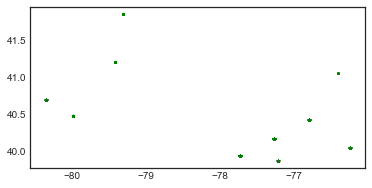

In [15]:
# PA2016["cde_agencies"].head()
# PA2016["nibrs_incident"].head()

tempDF= PA2016["cde_agencies"].merge(right = PA2016["nibrs_incident"], how = "inner", on = "agency_id")
# print(tempDF)
agencyLatLonDF = tempDF[["incident_id", "icpsr_lat", "icpsr_lng"]].rename(columns = {"icpsr_lat": "lat", "icpsr_lng": "lng"})
agencyLatLonDF['geometry'] = agencyLatLonDF.apply(lambda z: Point(z.lng, z.lat), axis=1)
agencyLatLonDF = gpd.GeoDataFrame(agencyLatLonDF)
# print(len(agencyLatLonDF["agency_id"].unique()))
# agencyLatLonDF.head()
agencyLatLonDF.crs = {'init' :'epsg:4326'}
agencyLatLonDF.plot(marker='*', color='green', markersize=5)

# Geospatial Analysis using GeoPandas

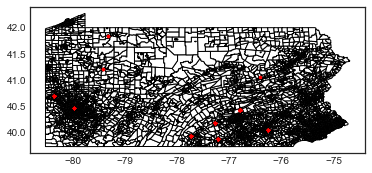

In [8]:
dfPA = gpd.read_file('PA-Geo/cb_2017_42_bg_500k.shp')
agencyLatLonDF = agencyLatLonDF.to_crs(dfPA.crs)

base = dfPA.plot(color='white', edgecolor='black')
agencyLatLonDF.plot(ax=base, marker='o', color='red', markersize=5)

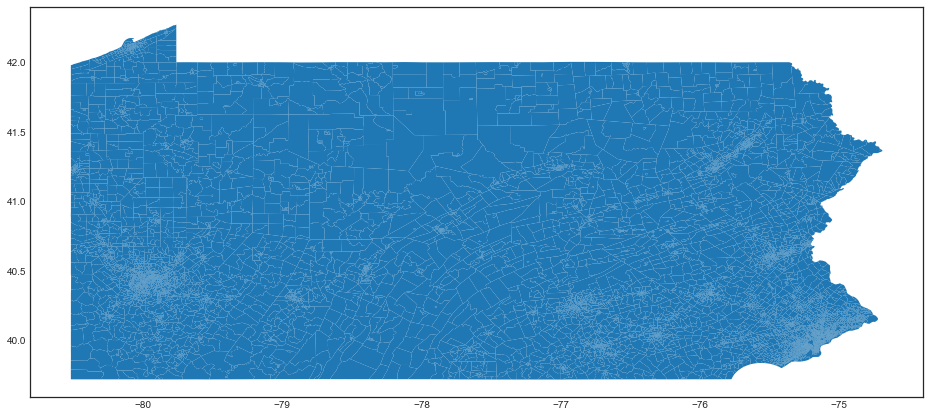

In [9]:
dfPA.plot(figsize=(16, 16))

In [10]:
cities.plot(marker='*', color='green', markersize=5)

NameError: name 'cities' is not defined